# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [61]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, hour, udf,countDistinct,desc,avg,from_unixtime,to_date,ceil,min
from pyspark.sql.types import StringType,DateType,IntegerType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when
import pyspark.sql.functions as F
from pyspark.sql import Window
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import matplotlib.ticker as ticker
import seaborn as sns

In [62]:
# create a Spark session
spark=SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [63]:
data = spark.read.json("mini_sparkify_event_data.json")
data

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [64]:
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [65]:
#shape of the dataframe
print((data.count(), len(data.columns)))

(286500, 18)


In [66]:
#Check for null/missing values values
data.select([F.count(F.when(F.col(i).isNull(), i)).alias(i) for i in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [67]:
data.filter(data["registration"].isNull()).count()
#data.filter(data["registration"].isNull()).show()

8346

In [68]:
#drop unregistered users
data=data.dropna(how="any",subset=["registration"])
#data.show()

In [69]:
#drop columns that are not needed
columns_to_drop = ['userAgent', 'firstName','lastName','location','song','artist','auth','method']

data=data.drop(*columns_to_drop)
data.show()

+------+-------------+---------+-----+---------------+-------------+---------+------+-------------+------+
|gender|itemInSession|   length|level|           page| registration|sessionId|status|           ts|userId|
+------+-------------+---------+-----+---------------+-------------+---------+------+-------------+------+
|     M|           50|277.89016| paid|       NextSong|1538173362000|       29|   200|1538352117000|    30|
|     M|           79|236.09424| free|       NextSong|1538331630000|        8|   200|1538352180000|     9|
|     M|           51| 282.8273| paid|       NextSong|1538173362000|       29|   200|1538352394000|    30|
|     M|           80|262.71302| free|       NextSong|1538331630000|        8|   200|1538352416000|     9|
|     M|           52|223.60771| paid|       NextSong|1538173362000|       29|   200|1538352676000|    30|
|     M|           81|208.29995| free|       NextSong|1538331630000|        8|   200|1538352678000|     9|
|     M|           82|260.46649| free

In [70]:
data.filter(data["page"]=="Submit Upgrade").count()


159

In [71]:
data.filter(data["page"]=="Submit Downgrade").count()

63

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [72]:
#create columns for downgraded,upgrade,paid and possible downgrade feature engineering
data=data.withColumn('downgrade', F.when(data.page=="Submit Downgrade", 1).otherwise(0))
data=data.withColumn('upgrade', F.when(data.page=="Submit Upgrade", 1).otherwise(0))
data=data.withColumn('posDowngrade', F.when(data.page=="Downgrade", 1).otherwise(0))
data=data.withColumn('sex', F.when(data.gender=="M", 1).otherwise(0))
data=data.drop('gender')
data=data.withColumn('paid', F.when(data.level=="paid", 1).otherwise(0))
data.show(10)

+-------------+---------+-----+---------------+-------------+---------+------+-------------+------+---------+-------+------------+---+----+
|itemInSession|   length|level|           page| registration|sessionId|status|           ts|userId|downgrade|upgrade|posDowngrade|sex|paid|
+-------------+---------+-----+---------------+-------------+---------+------+-------------+------+---------+-------+------------+---+----+
|           50|277.89016| paid|       NextSong|1538173362000|       29|   200|1538352117000|    30|        0|      0|           0|  1|   1|
|           79|236.09424| free|       NextSong|1538331630000|        8|   200|1538352180000|     9|        0|      0|           0|  1|   0|
|           51| 282.8273| paid|       NextSong|1538173362000|       29|   200|1538352394000|    30|        0|      0|           0|  1|   1|
|           80|262.71302| free|       NextSong|1538331630000|        8|   200|1538352416000|     9|        0|      0|           0|  1|   0|
|           52|223.6

In [73]:
#create a feature to look at the number of sessions a user has completed
feature_group = ['userId']
data_counts=data.groupBy(feature_group).agg(F.countDistinct('sessionId').alias("numSessions"))

data = data.join(data_counts, feature_group)


In [74]:
#add a column of registration date

data=data.withColumn('regDate',F.from_unixtime((F.col('registration')/1000),"yyyy-MM-dd"))
data=data.drop('registration')

In [75]:
data.show(3)

+------+-------------+---------+-----+--------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+
|userId|itemInSession|   length|level|    page|sessionId|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|
+------+-------------+---------+-----+--------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+
|    51|            6|     NULL| paid|    Home|      236|   200|1538398632000|        0|      0|           0|  1|   1|         10|2018-09-27|
|    51|            7|289.69751| paid|NextSong|      236|   200|1538398649000|        0|      0|           0|  1|   1|         10|2018-09-27|
|    51|            8|229.82485| paid|NextSong|      236|   200|1538398938000|        0|      0|           0|  1|   1|         10|2018-09-27|
+------+-------------+---------+-----+--------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+
only s

In [76]:
#create a feature to look at the ave items in session
w = Window.partitionBy(['userId','sessionId'])
data=data.withColumn("avgInSession", F.avg("itemInSession").over(w))
data=data.withColumn("avgInSession",F.ceil(F.col('avgInSession')))
data.show(5)

+------+-------------+---------+-----+---------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|userId|itemInSession|   length|level|     page|sessionId|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession|
+------+-------------+---------+-----+---------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|100010|            0|202.97098| free| NextSong|       31|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|
|100010|            1|196.54485| free| NextSong|       31|   200|1539003736000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|
|100010|            2|263.13098| free| NextSong|       31|   200|1539003932000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|
|100010|            3|     NULL| free|Thumbs Up|       31|   307

In [77]:
data.filter(data['downgrade']==1).show(5)

+------+-------------+------+-----+----------------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|userId|itemInSession|length|level|            page|sessionId|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession|
+------+-------------+------+-----+----------------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|    11|           23|  NULL| paid|Submit Downgrade|      487|   307|1539239742000|        1|      0|           0|  0|   1|         16|2018-07-25|          29|
|    54|           41|  NULL| paid|Submit Downgrade|      859|   307|1539608060000|        1|      0|           0|  0|   1|         37|2018-07-25|          34|
|   100|          203|  NULL| paid|Submit Downgrade|     1590|   307|1541367880000|        1|      0|           0|  1|   1|         35|2018-09-26|         156|
|100008|          565|  NULL| paid|Submi

In [78]:
data.filter(data['page']=="Downgrade").show(10)

+------+-------------+------+-----+---------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|userId|itemInSession|length|level|     page|sessionId|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession|
+------+-------------+------+-----+---------+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+
|100014|           90|  NULL| paid|Downgrade|       98|   200|1539724886000|        0|      0|           1|  1|   1|          6|2018-08-27|          48|
|100014|           24|  NULL| paid|Downgrade|      185|   200|1542730888000|        0|      0|           1|  1|   1|          6|2018-08-27|          37|
|100014|           71|  NULL| paid|Downgrade|      185|   200|1542740641000|        0|      0|           1|  1|   1|          6|2018-08-27|          37|
|   101|          194|  NULL| paid|Downgrade|      312|   200|1538541301000|      

In [79]:
#create a feature to see different start times of each sessions- will further look at time lapsed between different start times
feature_group = ['userId','sessionId']
data_min=data.groupBy(feature_group).agg(F.min('ts').alias("sessionStart"))
data=data.join(data_min, feature_group)

In [80]:
data.show(3)

+------+---------+-------------+------+-----+----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+
|userId|sessionId|itemInSession|length|level|      page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|
+------+---------+-------------+------+-----+----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+
|   101|      635|            2|  NULL| paid|      Home|   200|1539065365000|        0|      0|           0|  1|   1|         10|2018-08-24|         451|1539065365000|
|   101|      635|            3|  NULL| paid|Add Friend|   307|1539065366000|        0|      0|           0|  1|   1|         10|2018-08-24|         451|1539065365000|
|   101|      635|            4|  NULL| paid|    Logout|   307|1539065367000|        0|      0|           0|  1|   1|         10|2018-08-24|         451|1539065

In [81]:
data=data.withColumn('sessionSt',F.from_unixtime((F.col('sessionStart')/1000),"yyyy-MM-dd HH:mm:ss"))
data.show(8)

+------+---------+-------------+---------+-----+----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+
|userId|sessionId|itemInSession|   length|level|      page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|
+------+---------+-------------+---------+-----+----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+
|   101|      635|            2|     NULL| paid|      Home|   200|1539065365000|        0|      0|           0|  1|   1|         10|2018-08-24|         451|1539065365000|2018-10-09 08:09:25|
|   101|      635|            3|     NULL| paid|Add Friend|   307|1539065366000|        0|      0|           0|  1|   1|         10|2018-08-24|         451|1539065365000|2018-10-09 08:09:25|
|   101|      635|            4|     NULL| pa

In [82]:
#difference in days passed from previous session Start
w = Window.partitionBy('userId').orderBy('sessionSt')
data = data.withColumn("tPassed", F.datediff(data.sessionSt, 
                                  F.lag(data.sessionSt, 1).over(w)))

#fill null on tPassed Column with 0 for calculations later
data=data.na.fill(value=0,subset=["tPassed"])

In [83]:
data.show(10)

+------+---------+-------------+---------+-----+-----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|userId|sessionId|itemInSession|   length|level|       page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|
+------+---------+-------------+---------+-----+-----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|100010|       31|            0|202.97098| free|   NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|
|100010|       31|            1|196.54485| free|   NextSong|   200|1539003736000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|


In [84]:
data.dropDuplicates(['userId','sessionId']).show(5)

+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|userId|sessionId|itemInSession|   length|level|    page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|
+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|100010|       31|            0|202.97098| free|NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|
|100010|       78|            0|206.47138| free|NextSong|   200|1539603322000|        0|      0|           0|  0|   0|          7|2018-09-27|           4|1539603322000|2018-10-15 13:35:22|      7|
|100010|      1

In [85]:
data.show(10)

+------+---------+-------------+---------+-----+-----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|userId|sessionId|itemInSession|   length|level|       page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|
+------+---------+-------------+---------+-----+-----------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|100010|       31|            0|202.97098| free|   NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|
|100010|       31|            1|196.54485| free|   NextSong|   200|1539003736000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|


In [86]:
data.dropDuplicates(['userId','sessionId']).show(9)

+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|userId|sessionId|itemInSession|   length|level|    page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|
+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+
|100010|       31|            0|202.97098| free|NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|
|100010|       78|            0|206.47138| free|NextSong|   200|1539603322000|        0|      0|           0|  0|   0|          7|2018-09-27|           4|1539603322000|2018-10-15 13:35:22|      7|
|100010|      1

In [87]:
#total of time on app called sum of days active
userId_group = ['userId']
days_act=data.groupBy(['userId']).agg(F.sum('tPassed').alias("daysOn"))
data=data.join(days_act, userId_group)
data.show(5)

+------+---------+-------------+---------+-----+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+
|userId|sessionId|itemInSession|   length|level|     page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|daysOn|
+------+---------+-------------+---------+-----+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+
|100010|       31|            0|202.97098| free| NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|    44|
|100010|       31|            1|196.54485| free| NextSong|   200|1539003736000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 

In [88]:
#ave wait time before next session 
data = data.withColumn("aveWait", ceil(F.col("daysOn") / F.col("numSessions")))
data.show(5)

+------+---------+-------------+---------+-----+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|userId|sessionId|itemInSession|   length|level|     page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|daysOn|aveWait|
+------+---------+-------------+---------+-----+---------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|100010|       31|            0|202.97098| free| NextSong|   200|1539003534000|        0|      0|           0|  0|   0|          7|2018-09-27|          20|1539003534000|2018-10-08 14:58:54|      0|    44|      7|
|100010|       31|            1|196.54485| free| NextSong|   200|1539003736000|        0|      0|           0|  0|   0|          7|2018-09-27|      

In [89]:
data.groupBy(['userId','sessionId']).agg(F.sum('tPassed').alias("daysOn")).show(6)

+------+---------+------+
|userId|sessionId|daysOn|
+------+---------+------+
|    10|        9|     0|
|    10|      595|    10|
|    10|     1047|    12|
|    10|     1414|     4|
|    10|     1592|    12|
|    10|     1981|     4|
+------+---------+------+
only showing top 6 rows



In [90]:
data.groupBy(['userId']).agg(F.sum('tPassed')).show(6)

+------+------------+
|userId|sum(tPassed)|
+------+------------+
|    10|          42|
|   100|          59|
|100001|           1|
|100002|          55|
|100003|           2|
|100004|          56|
+------+------------+
only showing top 6 rows



In [91]:
data.filter(data['userId']==10).sort('ts').show(5)

+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|userId|sessionId|itemInSession|   length|level|    page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|daysOn|aveWait|
+------+---------+-------------+---------+-----+--------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|    10|        9|            0|265.53424| paid|NextSong|   200|1538965220000|        0|      0|           0|  1|   1|          6|2018-09-28|          36|1538965220000|2018-10-08 04:20:20|      0|    42|      7|
|    10|        9|            1| 200.4371| paid|NextSong|   200|1538965485000|        0|      0|           0|  1|   1|          6|2018-09-28|          3

In [92]:
data.filter(data['userId']==12).dropDuplicates(['userId','sessionId']).show()

+------+---------+-------------+---------+-----+--------------------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|userId|sessionId|itemInSession|   length|level|                page|status|           ts|downgrade|upgrade|posDowngrade|sex|paid|numSessions|   regDate|avgInSession| sessionStart|          sessionSt|tPassed|daysOn|aveWait|
+------+---------+-------------+---------+-----+--------------------+------+-------------+---------+-------+------------+---+----+-----------+----------+------------+-------------+-------------------+-------+------+-------+
|    12|       11|           25|244.55791| free|            NextSong|   200|1538542024000|        0|      0|           0|  0|   0|          9|2018-08-10|          13|1538533887000|2018-10-03 04:31:27|      0|    19|      3|
|    12|      379|          241|   33.802| paid|            NextSong|   200|1539051796000|        0|    

In [93]:
drop = ['sessionStart', 'sessionSt','regDate','ts']

data=data.drop(*drop)
data.show(10)

+------+---------+-------------+---------+-----+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+
|userId|sessionId|itemInSession|   length|level|       page|status|downgrade|upgrade|posDowngrade|sex|paid|numSessions|avgInSession|tPassed|daysOn|aveWait|
+------+---------+-------------+---------+-----+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+
|100010|       31|            0|202.97098| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|
|100010|       31|            1|196.54485| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|
|100010|       31|            2|263.13098| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|
|100010|       31|            3|     NULL| free|  Thumbs Up|   3

In [94]:
#create a feature to look at the number of sessions a user has completed
group = ['userId']
data_gender=data.groupBy(group).agg(F.max('downgrade').alias("churn"))

data = data.join(data_gender, group)


In [95]:
data.show(10)

+------+---------+-------------+---------+-----+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+-----+
|userId|sessionId|itemInSession|   length|level|       page|status|downgrade|upgrade|posDowngrade|sex|paid|numSessions|avgInSession|tPassed|daysOn|aveWait|churn|
+------+---------+-------------+---------+-----+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+-----+
|100010|       31|            0|202.97098| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|
|100010|       31|            1|196.54485| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|
|100010|       31|            2|263.13098| free|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|
|100010|       31|          

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [96]:
# convert to pandas for visualisation
df = data.toPandas()

In [97]:
df.head(4)

,userId,sessionId,itemInSession,length,level,page,status,downgrade,upgrade,posDowngrade,sex,paid,numSessions,avgInSession,tPassed,daysOn,aveWait,churn
0,100010,31,0,202.97098,free,NextSong,200,0,0,0,0,0,7,20,0,44,7,0
1,100010,31,1,196.54485,free,NextSong,200,0,0,0,0,0,7,20,0,44,7,0
2,100010,31,2,263.13098,free,NextSong,200,0,0,0,0,0,7,20,0,44,7,0
3,100010,31,3,NaN,free,Thumbs Up,307,0,0,0,0,0,7,20,0,44,7,0


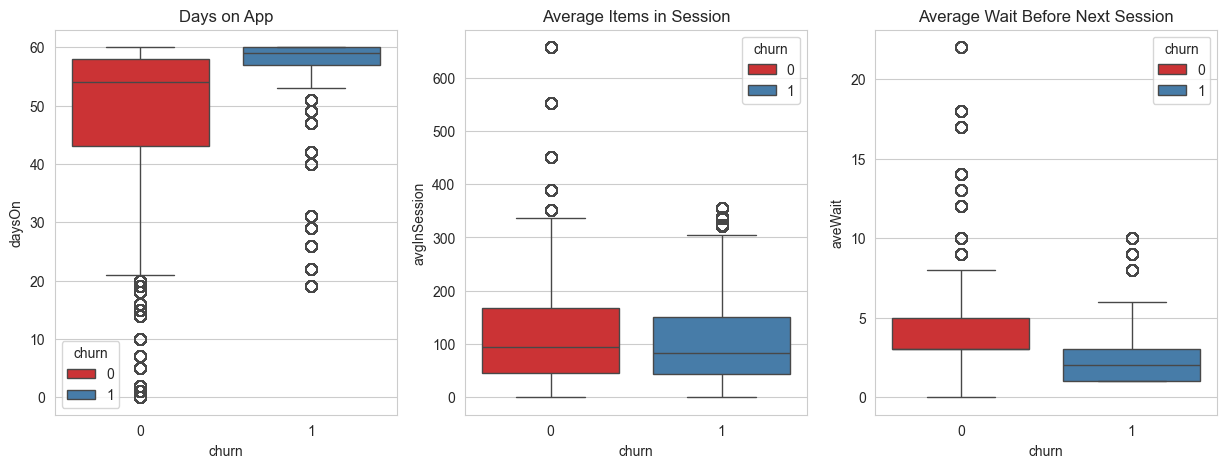

In [98]:
#look at how purchase amount is distributed acrossSeason, Category and Promocode 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.set_style("whitegrid")
sns.set_palette('Set1')
flierprops = dict(marker='o', markersize=8,
                  linestyle='none',markerfacecolor='none')
a=sns.boxplot(data=df,y="daysOn",x='churn',flierprops=flierprops,hue="churn",ax=axs[0])
b=sns.boxplot(data=df,y="avgInSession",x='churn',flierprops=flierprops,hue="churn",ax=axs[1])
c=sns.boxplot(data=df,y="aveWait",x='churn',flierprops=flierprops,hue="churn",ax=axs[2])
a.set(title='Days on App');
b.set(title='Average Items in Session');
c.set(title='Average Wait Before Next Session');

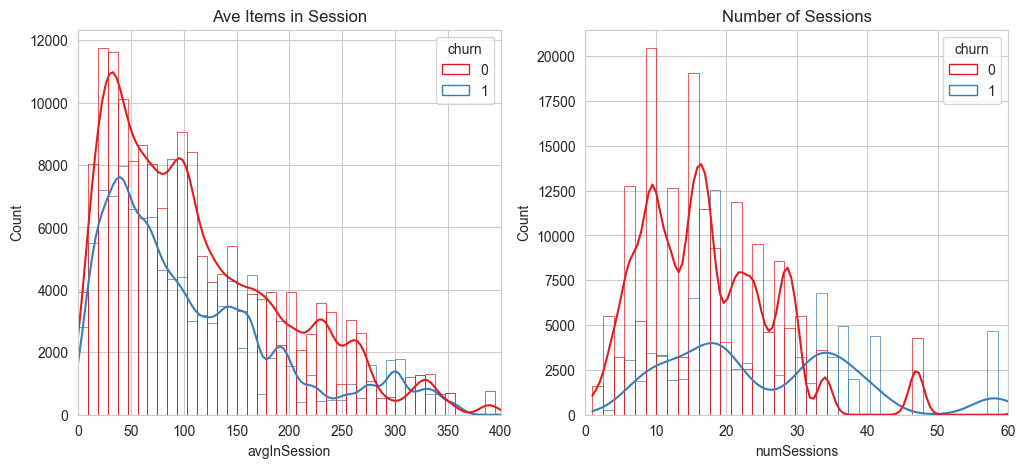

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
g=sns.histplot(data=df, x='avgInSession' ,bins=70,hue='churn',fill=False,kde=True,ax=axs[0])
g.set(title='Ave Items in Session')
g.set(xlim=(0, 400));
c=sns.histplot(data=df, x='numSessions' ,bins=70,hue='churn',fill=False,kde=True,ax=axs[1])
c.set(title='Number of Sessions')

c.set(xlim=(0, 60));

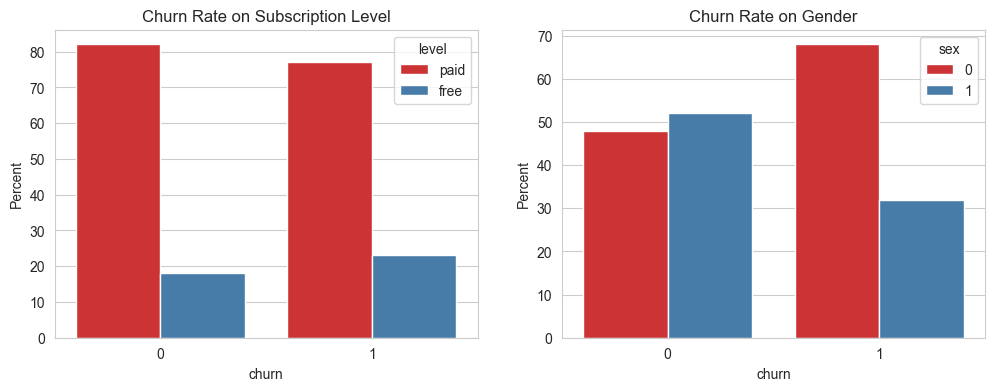

In [100]:
level=df.groupby('churn')['level'].value_counts(normalize=True).mul(100).round(0).rename("Percent").reset_index()
sex=df.groupby('churn')['sex'].value_counts(normalize=True).mul(100).round(0).rename("Percent").reset_index()

df.groupby('churn')['sex'].value_counts(normalize=True).mul(100).round(0).rename("Percent").reset_index()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
g=sns.barplot(data=level,x='churn',y="Percent",hue='level',ax=axs[0])
a=sns.barplot(data=sex,x='churn',y="Percent",hue='sex',ax=axs[1])
g.set(title='Churn Rate on Subscription Level');
a.set(title='Churn Rate on Gender');


# Modeling Testing
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [101]:
#Indexing level 
indexer=StringIndexer(inputCol='level',outputCol='levelIndexed')
data=indexer.fit(data).transform(data)
data=data.drop('level')
data.show()

+------+---------+-------------+---------+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+-----+------------+
|userId|sessionId|itemInSession|   length|       page|status|downgrade|upgrade|posDowngrade|sex|paid|numSessions|avgInSession|tPassed|daysOn|aveWait|churn|levelIndexed|
+------+---------+-------------+---------+-----------+------+---------+-------+------------+---+----+-----------+------------+-------+------+-------+-----+------------+
|100010|       31|            0|202.97098|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|         1.0|
|100010|       31|            1|196.54485|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|         1.0|
|100010|       31|            2|263.13098|   NextSong|   200|        0|      0|           0|  0|   0|          7|          20|      0|    44|      7|    0|

In [102]:
assembler = VectorAssembler(inputCols = ['aveWait','daysOn','tPassed','avgInSession','numSessions',
                                        'paid','sex',
                                        'posDowngrade','levelIndexed'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled')

In [103]:
#Split the Data into Train and Test Datasets
train, test = data.randomSplit([0.75, 0.25], seed=0)

In [104]:
evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1')
scores = []

 # Logistic Regression

In [105]:
# create pipeline with logistic regression classifier, using default settings, train model and measure score against test
logistic_regression_classifier = LogisticRegression(featuresCol='scaled', labelCol='churn')
pipeline = Pipeline(stages=[assembler, scaler, logistic_regression_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Logistic Regression', evaluator.evaluate(preds)])

In [106]:
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
scores_df.head()

,Classifier,F1 Score
0,Logistic Regression,0.733399


# Random Forest

In [107]:

random_forest_classifier = RandomForestClassifier(featuresCol='scaled', labelCol='churn')
pipeline = Pipeline(stages=[assembler, scaler, random_forest_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['Random Forest', evaluator.evaluate(preds)])

In [108]:
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
scores_df.head()

,Classifier,F1 Score
0,Logistic Regression,0.733399
1,Random Forest,0.822556


# Gradient Boost

In [109]:
gbt_classifier = GBTClassifier(featuresCol='scaled', labelCol='churn')
pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier])
model = pipeline.fit(train)
preds = model.transform(test)
scores.append(['GBT Classifier', evaluator.evaluate(preds)])

In [110]:
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
scores_df.head()

,Classifier,F1 Score
0,Logistic Regression,0.733399
1,Random Forest,0.822556
2,GBT Classifier,0.918992


# GBT Optimized

In [111]:
pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier])

param_grid = ParamGridBuilder()\
.addGrid(gbt_classifier.maxDepth, [2,5])\
.build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluator,
                    numFolds=2)
model = cv.fit(train)
preds = model.transform(test)
scores.append(['GBT classifier- Optimized', evaluator.evaluate(preds)])

In [112]:
scores_df = pd.DataFrame(scores,columns=['Classifier', 'F1 Score'])
scores_df.head()

,Classifier,F1 Score
0,Logistic Regression,0.733399
1,Random Forest,0.822556
2,GBT Classifier,0.918992
3,GBT classifier- Optimized,0.920079


[(0.5, 1.0)]

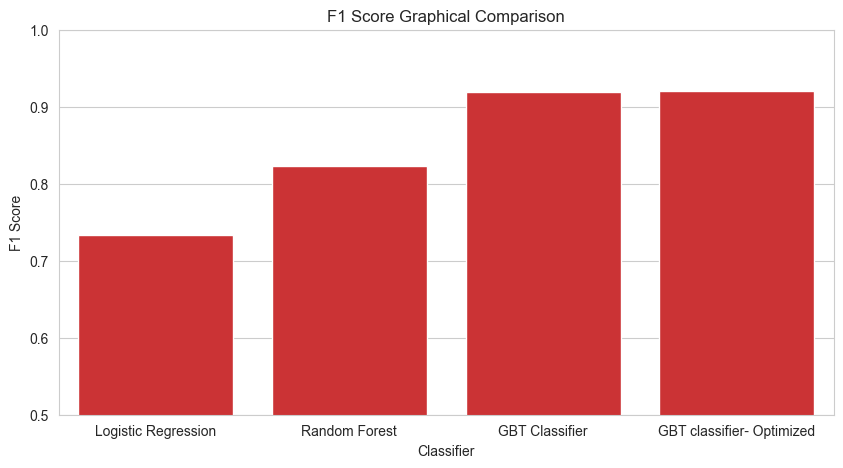

In [113]:
#plot F1 score output
plt.figure(figsize=(10,5))
a = sns.barplot(data=scores_df, x ="Classifier",y="F1 Score")
a.set(title='F1 Score Graphical Comparison');
a.set(ylim=(0.5,1.0))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.